# MDN_RNN
___
* MDN-RNN output: next latent vector z
* see training params

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path
path = str(Path(os.getcwd()).parent)
import_path = str(Path(os.getcwd()).parent.parent)

import sys
sys.path.insert(0,path)
from breakout.rnn.rnn import RNNModel, hps_sample, rnn_init_state
from breakout.vae.vae import ConvVAE

sys.path.insert(0, import_path)
from WorldModelsExperiments.breakout.model import Model, _process_frame

In [3]:
server = True
if server:
    rnn_path = path + '/breakout/results_200218/tf_rnn'
    series_path = path + '/breakout/results_200218/series'
    vae_path = path + '/breakout/results_200218/tf_vae'
    obs_path = path + '/breakout/results_200218/record'

## See MDN-RNN output
from Model()

In [5]:
model = Model(load_model=True, rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

/home/student/PycharmProjects/worldmodel/venv/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
RNN/output_w:0
RNN/output_b:0
RNN/layer_norm_basic_lstm_cell/kernel:0
RNN/layer_norm_basic_lstm_cell/bias:0


In [6]:
# nope
obs = model.env.reset()
obs = _process_frame(obs)

z, mu, logvar= model.encode_obs(obs)

state = model.state #model.state = rnn.sess.run(rnn.initial_state) # LSTMState Tuple - c,h
state

h = np.concatenate([z,state.h[0]])
weight = model.weight
bias = model.bias
action = np.argmax(np.matmul(h, weight)+ bias)
action_one_hot = np.zeros(model.num_actions)
action_one_hot[action] = 1

input_x = np.concatenate((z.reshape((1, 1, 32)), action_one_hot.reshape((1, 1, 4))), axis=2)
feed = {
    model.rnn.input_x: input_x,
    model.rnn.initial_state: state
}

[logmix, mean, logstd, next_state] = model.rnn.sess.run([
    model.rnn.out_logmix, model.rnn.out_mean, model.rnn.out_logstd, model.rnn.final_state],
    feed
) # different output from rnn_mdn

In [7]:
z_dim = 32
chosen_log_pi = np.zeros(z_dim)
chosen_mu = np.zeros(z_dim)
chosen_log_sigma = np.zeros(z_dim)

#adjust temp
pi = np.copy(logmix) #/temperature
logmix2 = np.exp(pi)
logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)
logmix2.shape

(32, 5)

In [8]:
from gym.utils import seeding
np_random, seed = seeding.np_random()

In [10]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [12]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) * 0.5
    return z

In [13]:
for j in range(z_dim):
    idx = get_pi_idx(np_random.rand(), logmix2[j])
    chosen_log_pi[j] = idx
    chosen_mu[j] = mean[j, idx]
    chosen_log_sigma[j] = logstd[j,idx]
    
next_z = sample_z(chosen_mu, chosen_log_sigma)
next_z.shape

(32,)

INFO:tensorflow:Model using gpu.


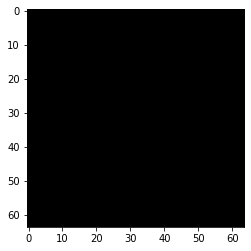

In [15]:
from breakout.vae.vae import ConvVAE
vae = ConvVAE()
vae.load_json(os.path.join(vae_path, 'vae.json'))

next_z = next_z.reshape(1,32)
next_z_decoded = vae.decode(next_z)
next_z_decoded = next_z_decoded.reshape(64,64,3)

plt.imshow(next_z_decoded)
plt.show()

In [ ]:
def get_mdn_coef(output):
    logmix, mean, logstd = tf.split(output,3,axis=1)
    logmix = logmix - tf.reduce_logsumexp(logmix, 1, keepdims=True) # todo ????????
    return logmix, mean, logstd

get observation and action from collected data - not ready yet net missing.

In [ ]:
def load_raw_data_list(filelist):
    data_list = []
    action_list = []
    counter = 0
    for i in range(len(filelist)):
        filename = filelist[i]
        raw_data = np.load(os.path.join(obs_path, filename))
        data_list.append(raw_data['obs'])
        action_list.append(raw_data['action'])
        if ((i+1) % 1000 == 0):
            print("loading file", (i+1))
    return data_list, action_list

In [ ]:
filelist = os.listdir(obs_path)
filelist.sort()
filelist = filelist[0:10]
dataset, action_dataset = load_raw_data_list(filelist[0:10])

In [ ]:
dataset[0][0].shape

In [ ]:
def encode_obs(obs):
    # convert raw obs to z, mu, logvar
    #result = np.copy(obs).astype(np.float)/255.
    result = np.expand_dims(obs, axis=0)#reshape(1, 64, 64, 3)
    mu, logvar = vae.encode_mu_logvar(result)
    mu = mu[0] #
    logvar = logvar[0]
    s = logvar.shape
    z = mu + np.exp(logvar/2.0) * np.random.randn(*s)
    return z, mu, logvar

In [ ]:
vae = ConvVAE()
z, mu, logvar = encode_obs(dataset[0][0])

In [ ]:
mdnrnn = RNNModel(hps=hps_sample)
mdnrnn.load_json(os.path.join(rnn_path, 'rnn.json'))

In [ ]:
state = rnn_init_state(mdnrnn)
h = np.concatenate([z,state.h[0]])
h.shape

In [ ]:
input_x = np.concatenate((z.reshape(1,1,32), action_dataset[0][0].reshape(1,1,4)), axis=2)
input_x.shape

In [ ]:
feed = {
    mdnrnn.input_x: input_x,
    mdnrnn.initial_state: state
}
output, next_state = mdnrnn.sess.run(mdnrnn.final_state, feed)
output.shape

In [ ]:
with tf.variable_scope('RNN'):
    output_w = tf.get_variable("output_w", [hps_sample.rnn_size, 480])
    output_b = tf.get_variable("output_b", [480])

In [ ]:
output = tf.reshape(output, [-1, hps_sample.rnn_size])
output = tf.nn.xw_plus_b(output, output_w, output_b)
output = tf.reshape(output, [-1, hps_sample.num_mixture * 3])

In [ ]:
logmix, mean, logstd = get_mdn_coef(output)

get observation from env.reset() and action from some nn - same. not ready yet. using a random sampled net

In [ ]:
logmix

In [ ]:
obs = model.env.reset()
obs = _process_frame(obs)

z, mu, logvar= model.encode_obs(obs)

state = model.state  # LSTMState Tuple - c,h

h = np.concatenate([z,state.h[0]])
weight = model.weight
bias = model.bias
action = np.argmax(np.matmul(h, weight)+ bias)
action_one_hot = np.zeros(model.num_actions)
action_one_hot[action] = 1

input_x = np.concatenate((z.reshape((1, 1, 32)), action_one_hot.reshape((1, 1, 4))), axis=2)
feed = {
    model.rnn.input_x: input_x,
    model.rnn.initial_state: state
}
output, next_state = model.rnn.sess.run(model.rnn.final_state, feed)

output.shape # (1,256) ; rnn_size = 256
# TODOOOO needs to adapt output shape to (None, 480)
output = np.matmul(output, np.random.rand(256,480))
output = tf.reshape(output, [-1, mdnrnn.num_mixture*3])
# todo needs to resh
output.shape
logmix, mean, logstd = get_mdn_coef(output)

In [ ]:
with tf.Session() as sess:
    logmix = logmix.eval(session=sess)
    mean = mean.eval(session=sess)
    logstd = logstd.eval(session=sess)
    

In [ ]:
# load series data
raw_data = np.load(os.path.join(series_path, "series.npz"))
data_mu = raw_data["mu"]
data_logvar = raw_data["logvar"]
data_action =  raw_data["action"]
data_mu.shape

In [ ]:
# define batch ? 
# continue with https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/check_04_rnn.ipynb
e = np.random.randn(*data_logvar.shape)
data_z = data_mu + np.exp(data_logvar/2.0)*e # todo recheck why logvar/2.0
data_z.shape

In [ ]:
rnn_input = np.concatenate((data_z[:,:-1,:],data_action[:,:-1,:]), axis=2)
rnn_input.shape # len_filelist, seq_length-1, z_dim+4

In [ ]:
model = Model(load_model=True, rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))
m_state = model.state
m_state


In [ ]:
obs.shape


## Training Param

In [ ]:
with open(path + '/breakout/tf_rnn/rnn_train_param.json', 'r') as file:
    train_param = json.load(file)
train_cost = []
curr_learning_rate = []
for params in train_param:
    train_cost.append(params['train_cost'])
    
plt.plot(train_cost, label='Train Cost')
plt.legend(loc='upper right')
plt.xlabel('Steps')
plt.titel('Params during Training')
plt.show()